In [1]:
import pandas as pd
import numpy as np
import pymysql
from sqlalchemy import create_engine
import re
import os
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import math
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow import keras

## 讀取檔案

In [3]:
username = 'root'
password = 'yuting1101'
host_port = 'localhost:3306' 
database = 'twfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [4]:
fruit = "banana"
market = "台北二"
df= pd.read_sql(f"{fruit}_{market}", engine)
df

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
0,2011-01-01,31.4,9645.0,36.5,45.0,31.4,32.2
1,2011-01-02,32.0,12230.0,50.0,47.5,31.4,32.2
2,2011-01-03,32.2,12103.0,46.2,47.5,32.0,32.2
3,2011-01-04,32.4,11976.0,42.5,47.5,32.2,32.2
4,2011-01-05,33.2,7520.0,34.8,45.8,32.4,32.2
...,...,...,...,...,...,...,...
3868,2021-08-04,37.9,5550.0,35.2,31.4,35.2,37.7
3869,2021-08-05,40.7,5530.0,38.0,29.3,37.9,38.3
3870,2021-08-06,38.3,5891.0,38.6,32.9,40.7,38.0
3871,2021-08-07,46.1,4681.0,42.3,29.9,38.3,39.6


In [5]:
df["中價"] = df["banana_平均價"].apply(lambda x: round(x,0))
df

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價,中價
0,2011-01-01,31.4,9645.0,36.5,45.0,31.4,32.2,31.0
1,2011-01-02,32.0,12230.0,50.0,47.5,31.4,32.2,32.0
2,2011-01-03,32.2,12103.0,46.2,47.5,32.0,32.2,32.0
3,2011-01-04,32.4,11976.0,42.5,47.5,32.2,32.2,32.0
4,2011-01-05,33.2,7520.0,34.8,45.8,32.4,32.2,33.0
...,...,...,...,...,...,...,...,...
3868,2021-08-04,37.9,5550.0,35.2,31.4,35.2,37.7,38.0
3869,2021-08-05,40.7,5530.0,38.0,29.3,37.9,38.3,41.0
3870,2021-08-06,38.3,5891.0,38.6,32.9,40.7,38.0,38.0
3871,2021-08-07,46.1,4681.0,42.3,29.9,38.3,39.6,46.0


### 單一市場測試

In [6]:
# 測試
from my_libs.my_model_trainer_banana import *

Ongoing: banana_台北一==========================================================================================
X's shape: (3063, 30, 7)
y's shape: (3063, 7)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            18432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 5s 69ms/step - loss: 1.3769 - val_loss: 0.

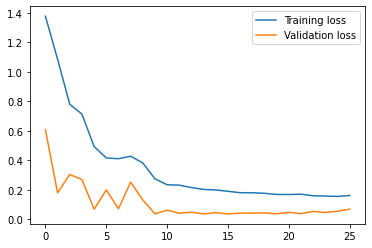

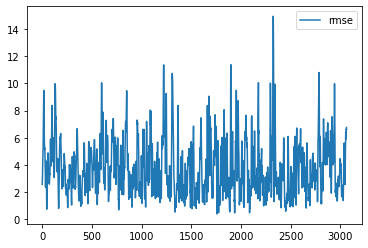

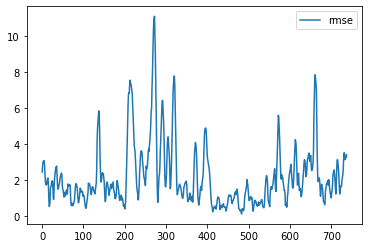

In [7]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

pred_list = []
actual_list = []

n_future = 7
n_past = 30

Fruit = 'banana'
market = '台北一'

# for Fruit, Type in fruits.items():
#     for market in markets:

print(f"Ongoing: {Fruit}_{market}" + "==="*30)

# 讀取分析資料
df_merged = pd.read_sql(f"{Fruit}_{market}", engine)
df_merged["中價"] = df_merged["banana_平均價"].apply(lambda x: round(x,0))


# 訓練集、測試集
train_set, test_set = train_test_split(df_merged)

### 訓練集part
# 訓練集(sc)、訓練集預測(scaler)
train_set_sc, sc_train_target = data_normalization(train_set)

# 訓練集
X_train, y_train = split_Xy(train_set_sc, n_future=n_future, n_past=n_past)

# 創造momdel
model = model_creator(n_past=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

# 訓練model
trained_model = model_trainer(model, X_train, y_train, epoch=30, batch_size=128, loss_visualize=True)

# 訓練集驗證
prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

### 測試集part
# 測試集(sc)、測試集預測(scaler)
test_set_sc, sc_test_target = data_normalization(test_set)

# 測試集、test_scaler
X_test, y_test = split_Xy(test_set_sc, n_future=n_future, n_past=n_past)

# 測試集驗證
prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)

pred_list.append(prediction_test)
actual_list.append(actual_test)

#         # 儲存模型
#         #trained_model.save(f"C:/Users/Tibame/PycharmProjects/PythonETL/Fruit Price Prediction/models/{Fruit}_Price/{market}.h5")



<AxesSubplot:>

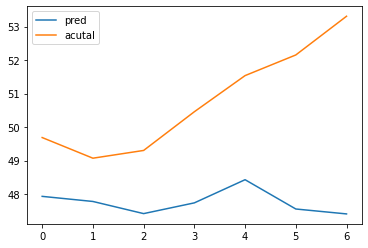

In [8]:
index = -1
pred = pred_list[0][index].reshape(-1).tolist()
acutal = actual_list[0][index].tolist()

df_visual = pd.DataFrame({"pred":pred, "acutal":acutal})
df_visual.plot()

### 四大市場共同測試

In [ ]:
# 測試
from my_libs.my_model_trainer_banana import *

Ongoing: banana_台北二==========================================================================================
X's shape: (3010, 60, 6)
y's shape: (3010, 30)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 60, 64)            18176     
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                990       
Total params: 31,582
Trainable params: 31,582
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
19/19 [==============================] - 4s 97ms/step - loss: 2.9031 - val_loss

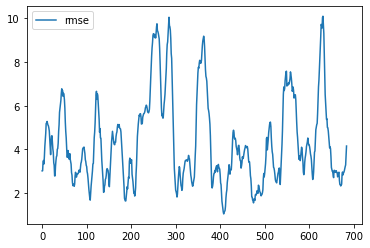

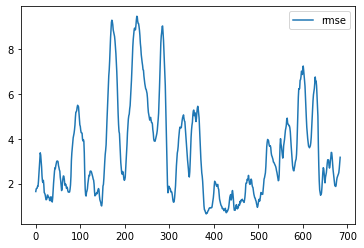

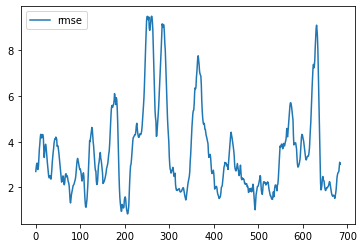

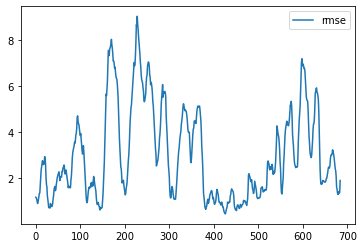

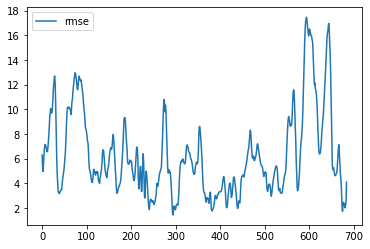

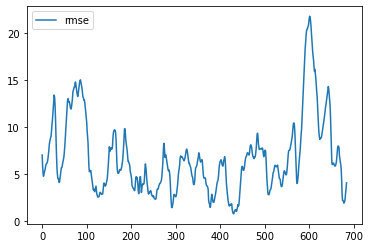

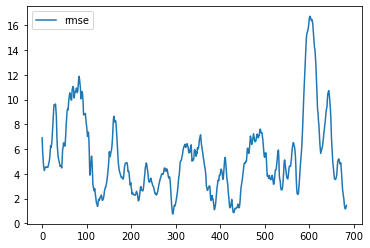

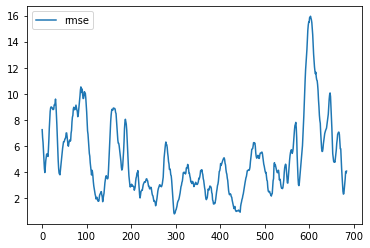

In [104]:
fruits = {"banana": ["banana", "scarletbanana", "guava"],
          "guava":  ["guava", 'emperorguava', 'banana']}

markets = ['台北二', '台北一', '三重區', '台中市']

pred_list = []
actual_list = []

# 參數設定
n_future = 30
n_past = 60
epochs = 30
batch_size = 128


for Fruit, Type in fruits.items():
    for market in markets:
        print(f"Ongoing: {Fruit}_{market}" + "==="*30)
        
        # 讀取分析資料
        df_merged = pd.read_sql(f"{Fruit}_{market}", engine)
    
        # 訓練集、測試集
        train_set, test_set = train_test_split(df_merged)

        ### 訓練集part
        # 訓練集(sc)、訓練集預測(scaler)
        train_set_sc, sc_train_target = data_normalization(train_set)

        # 訓練集
        X_train, y_train = split_Xy(train_set_sc, n_future=n_future, n_past=n_past)

        # 創造momdel
        model = model_creator(n_past=X_train.shape[1], n_features=X_train.shape[2], output=y_train.shape[1])

        # 訓練model
        trained_model = model_trainer(model, X_train, y_train, epoch=epochs, batch_size=batch_size)

        # 訓練集驗證
        # prediction_train, actual_train = model_validation(trained_model, X_train, y_train, sc_train_target)

        ### 測試集part
        # 測試集(sc)、測試集預測(scaler)
        test_set_sc, sc_test_target = data_normalization(test_set)

        # 測試集、test_scaler
        X_test, y_test = split_Xy(test_set_sc, n_future=n_future, n_past=n_past)

        # 測試集驗證
        prediction_test, actual_test = model_validation(trained_model, X_test, y_test, sc_test_target)
        
        pred_list.append(prediction_test)
        actual_list.append(actual_test)
    break
        # 儲存模型
        #trained_model.save(f"C:/Users/Tibame/PycharmProjects/PythonETL/Fruit Price Prediction/models/{Fruit}_Price/{market}.h5")

### Visualization

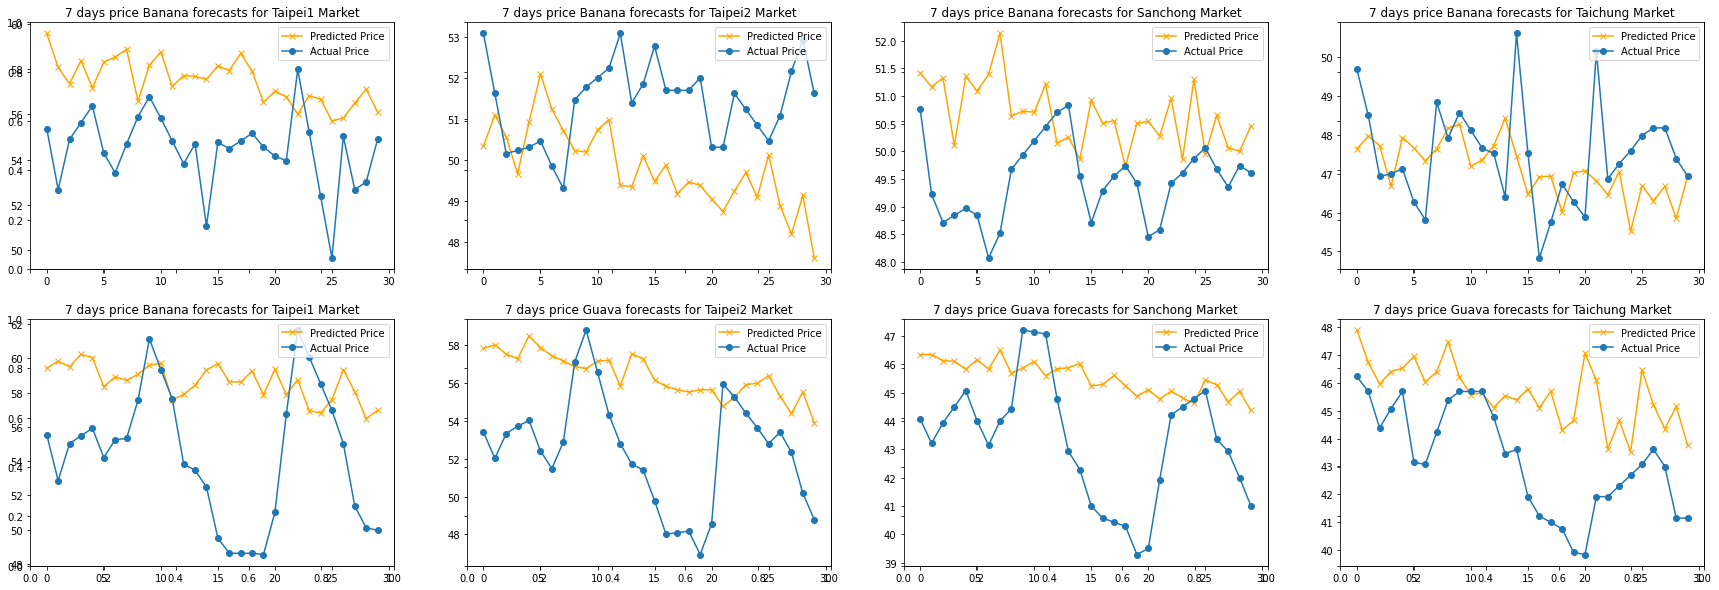

In [108]:
fig, axes = plt.subplots(2, 4, figsize=(30,10), sharex=True, sharey=True) #, squeeze=True)

#     ax.xaxis.set_major_locator(plt.NullLocator())
#     ax.yaxis.set_major_locator(plt.NullLocator())

markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
fruits = ["Banana", "Guava"]

n = 30
index = 200 # 200

for i in list(range(8)):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(np.arange(n), pred_list[i][index][:n], label="Predicted Price", color="orange", marker="x")
    ax.plot(np.arange(n), actual_list[i][index][:n], label="Actual Price", marker="o")
    #ax.set_xticks(np.arange(0, 31, 5))
    if i <= 4:
        fruit = fruits[0]
    else:
        fruit = fruits[1]
        
    ax.set_title(f"7 days price {fruit} forecasts for {markets[i%4]} Market")
    #ax.set_yticks(np.arange(0, 50, 10))
    
    ax.legend(loc="upper right")
    
    

### 預測結果評估(rmse, mape, mad)
- mape : 平均絕對百分比誤差(Mean absolute percentage error)
- rmse : 均方根差(root-mean-square error)
- mad : 平均絕對偏差（Mean Absolute Deviation)

In [94]:
# mean_absolute_percentage_error => sklearn版本問題無法import
from sklearn.metrics import mean_squared_error

In [95]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [96]:
def mad(y_true, y_pred):
    return sum(np.abs((y_true - y_pred) / len(y_true)))

In [106]:
rmse_output = []
mape_output = []
mad_output = []

n = -1

for i in list(range(8)):
    rmse_output.append(mean_squared_error(pred_list[i][n], actual_list[i][n], squared=False))
    mape_output.append(mape(actual_list[i][n], pred_list[i][n]))
    mad_output.append(mad(pred_list[i][n], actual_list[i][n]))

indexs = ['Banana_Taipei1', 'Banana_Taipei2', 'Banana_Sanchong', 'Banana_Taichung',
        'Guava_Taipei1', 'Guava_Taipei2', 'Guava_Sanchong','Guava_Taichung']

df_result_evaluation = pd.DataFrame({"RMSE" : rmse_output,
                                     "MAPE" : mape_output,
                                     "MAD" : mad_output}, index= indexs)

df_result_evaluation

,RMSE,MAPE,MAD
Banana_Taipei1,4.158215,6.796682,3.432164
Banana_Taipei2,3.174378,5.692355,2.695272
Banana_Sanchong,3.013849,5.975494,2.558469
Banana_Taichung,1.900866,3.212754,1.443559
Guava_Taipei1,4.084779,5.559400,3.327233
Guava_Taipei2,4.085762,6.579808,3.753267
Guava_Sanchong,1.454126,2.601404,1.205610
Guava_Taichung,4.071126,7.930595,3.536221
